In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *
from skimage.util import montage
import pandas as pd
from torch import optim
import re

from utils import *

In [114]:
# import fastai
# from fastprogress import force_console_behavior
# import fastprogress
# fastprogress.fastprogress.NO_BAR = True
# master_bar, progress_bar = force_console_behavior()
# fastai.basic_train.master_bar, fastai.basic_train.progress_bar = master_bar, progress_bar

It is mildly annoying that people are able to get to ~0.61 on the LB using a pretrained CNN on full images, which is a level of performance that has eluded us thus far. Let's see if we can change this!

To improve the score, these are some of the things we will do:
* train longer and on bigger images
* use biggger or newer architecture (though this is slightly annoying as it would make the training run much longer, maybe it can be avoided)
* use more data augmentation
* balancing the classes
* ~~more aggressively tune the threshold for the 'new_whale' label (this is also a great way to get into trouble on the test set)~~
* retrain on the entire train set (particularly important for whales with just a couple of pictures)
* if this does not give us adequate level of performance, I will attempt SWA or some other form of ensembling

## Prepare data

In [2]:
df = pd.read_csv('data/train.csv')
df.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [3]:
im_count = df[df.Id != 'new_whale'].Id.value_counts()
im_count.name = 'sighting_count'
df = df.join(im_count, on='Id')
val_fns = set(df.sample(frac=1)[(df.Id != 'new_whale') & (df.sighting_count > 1)].groupby('Id').first().Image)

/home/radek/anaconda3/envs/fastai_n/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [3]:
# pd.to_pickle(val_fns, 'data/val_fns')
val_fns = pd.read_pickle('data/val_fns')

In [22]:
fn2label = {row[1].Image: row[1].Id for row in df.iterrows()}

In [5]:
SZ = 224
BS = 64
NUM_WORKERS = 12
SEED=0

In [6]:
path2fn = lambda path: re.search('\w*\.jpg$', path).group(0)

In [101]:
data = (
    ImageItemList
        .from_df(df[df.Id != 'new_whale'], 'data/train', cols=['Image'])
        .split_by_valid_func(lambda path: path2fn(path) in val_fns)
        .label_from_func(lambda path: fn2label[path2fn(path)])
        .add_test(ImageItemList.from_folder('data/test'))
        .transform(get_transforms(do_flip=False), size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
        .normalize(imagenet_stats)
)

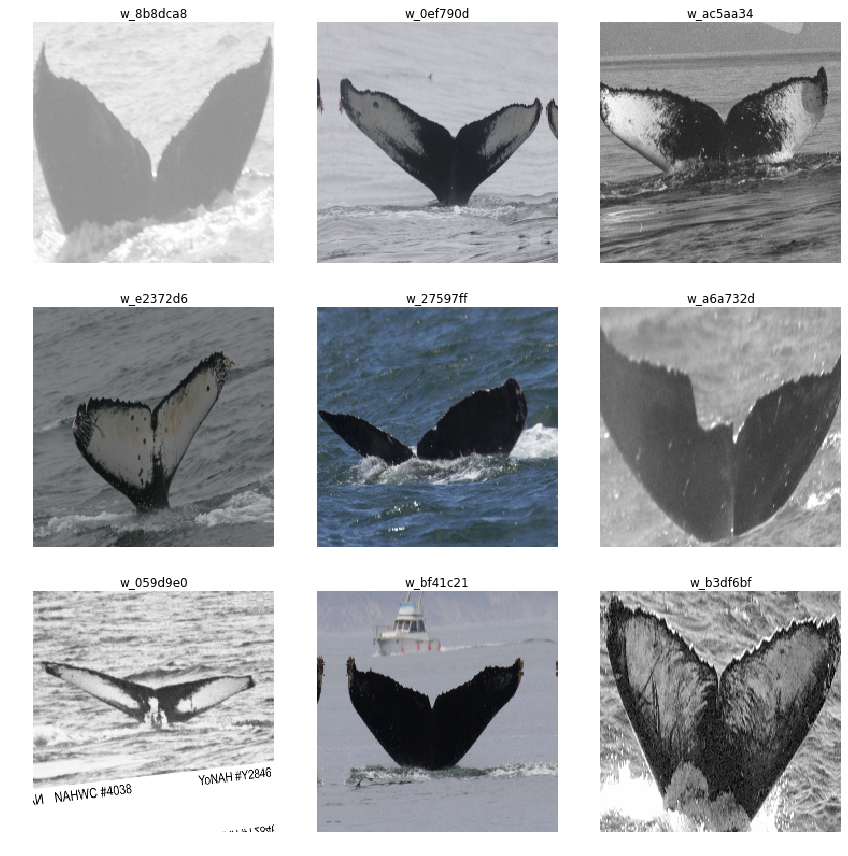

In [102]:
data.show_batch(rows=3)

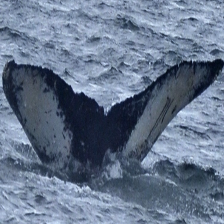

In [110]:
data.train_ds[1][0]

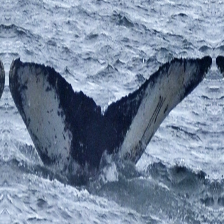

In [111]:
data.train_ds[1][0]

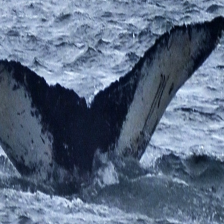

In [112]:
data.train_ds[1][0]

## Train

In [5]:
name = f'res50-tuned-{SZ}'

Warning - code below captures the gist of the experiments I ran, but now looking at the results I think I may have deleted some lines where I load weights, etc. Doesn't really matter, this still has all the info I need to train on the full train set.

In [ ]:
# transform(get_transforms(do_flip=False), size=SZ, resize_method=ResizeMethod.SQUISH)

learn = create_cnn(data, models.resnet50, metrics=[accuracy, map5], lin_ftrs=[2048])
learn.clip_grad();

learn.fit_one_cycle(12, 1e-2)

learn.unfreeze()

max_lr = 1e-3
lrs = [max_lr/100, max_lr/10, max_lr]

learn.fit_one_cycle(20, lrs)

epoch     train_loss  valid_loss  accuracy  map5    
1         7.454428    7.943007    0.035483  0.047299  
2         6.899120    7.930930    0.042306  0.059627  
4         5.335433    7.081480    0.080519  0.112197  
5         4.411437    6.089827    0.151484  0.193239  
6         3.577721    5.602340    0.200273  0.250688  
7         2.521963    4.918417    0.280109  0.338616  
8         1.577068    4.531044    0.334357  0.400762  
9         0.750727    4.290781    0.383146  0.443705  
10        0.375632    4.071115    0.420334  0.480257  
11        0.199115    4.050641    0.420676  0.484283  
12        0.145722    4.014052    0.425452  0.486967  
epoch     train_loss  valid_loss  accuracy  map5    
1         0.145415    4.000054    0.424770  0.488064  
2         0.164116    4.049176    0.422723  0.483401  
3         0.217732    4.218015    0.398840  0.461646  
4         0.282814    4.326548    0.390993  0.453025  
5         0.365246    4.304739    0.384169  0.445377  
6         0.38

In [119]:
# SZ = 448
# transform(get_transforms(do_flip=False), size=SZ, resize_method=ResizeMethod.SQUISH)

learn = create_cnn(data, models.resnet50, metrics=[accuracy, map5], lin_ftrs=[2048])
learn.clip_grad();

learn.fit_one_cycle(12, 1e-2)

learn.unfreeze()

max_lr = 1e-3
lrs = [max_lr/100, max_lr/10, max_lr]

learn.fit_one_cycle(20, lrs)
learn.save('tmp')

epoch     train_loss  valid_loss  accuracy  map5    
1         7.458901    7.879482    0.033436  0.047254  
2         6.821183    8.227102    0.036847  0.057398  
3         6.288155    7.642523    0.051518  0.071096  
4         5.343709    6.897586    0.078130  0.109075  
5         4.422855    5.901004    0.155919  0.198903  
6         3.569579    5.285469    0.216308  0.267195  
7         2.551295    4.887350    0.280450  0.337291  
8         1.549548    4.450785    0.341180  0.404413  
9         0.811041    4.187665    0.399522  0.458717  
10        0.400040    3.994130    0.418628  0.479666  
11        0.213965    3.923203    0.433299  0.492892  
12        0.146779    3.924941    0.436370  0.496247  
epoch     train_loss  valid_loss  accuracy  map5    
1         0.135797    3.884549    0.435687  0.497913  
2         0.170823    3.927935    0.432958  0.493131  
3         0.213713    4.031115    0.417946  0.479188  
4         0.287223    4.225440    0.388263  0.452132  
5         0.35

In [3]:
SZ = 224 * 2
BS = 64 // 4
NUM_WORKERS = 12
SEED=0

In [ ]:
df = pd.read_csv('data/oversampled_train.csv')

In [10]:
data = (
    ImageItemList
        .from_df(df[df.Id != 'new_whale'], 'data/train', cols=['Image'])
        .split_by_valid_func(lambda path: path2fn(path) in val_fns)
        .label_from_func(lambda path: fn2label[path2fn(path)])
        .add_test(ImageItemList.from_folder('data/test'))
        .transform(get_transforms(do_flip=False), size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
        .normalize(imagenet_stats)
)

In [12]:
%%time
# SZ = 448
# transform(get_transforms(do_flip=False), size=SZ, resize_method=ResizeMethod.SQUISH)
# oversampled without val

learn = create_cnn(data, models.resnet50, metrics=[accuracy, map5], lin_ftrs=[2048])
learn.clip_grad();
learn.load('tmp');
learn.freeze_to(-1)

learn.fit_one_cycle(2, 1e-2 / 4)

learn.unfreeze()

max_lr = 1e-3 / 4
lrs = [max_lr/100, max_lr/10, max_lr]

learn.fit_one_cycle(3, lrs)

epoch,train_loss,valid_loss,accuracy,map5
1,1.122527,3.734909,0.449676,0.501223
2,0.274912,2.789104,0.607301,0.651109


epoch,train_loss,valid_loss,accuracy,map5
1,0.325346,2.897968,0.607642,0.651581
2,0.200637,2.805774,0.635960,0.677579
3,0.160262,2.719925,0.654043,0.694115


CPU times: user 1h 30min 35s, sys: 39min 9s, total: 2h 9min 44s
Wall time: 2h 9min 58s


## Adding new_whale to predictions 

In [18]:
df = pd.read_csv('data/train.csv')

In [19]:
new_whale_fns = set(df[df.Id == 'new_whale'].sample(frac=1).Image.iloc[:1000])

In [23]:
data = (
    ImageItemList
        .from_df(df, 'data/train', cols=['Image'])
        .split_by_valid_func(lambda path: path2fn(path) in val_fns.union(new_whale_fns))
        .label_from_func(lambda path: fn2label[path2fn(path)], classes=learn.data.classes)
        .add_test(ImageItemList.from_folder('data/test'))
        .transform(get_transforms(do_flip=False, max_zoom=1, max_warp=0, max_rotate=2), size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
        .normalize(imagenet_stats)
)

In [24]:
data

ImageDataBunch;

Train: LabelList
y: CategoryList (21430 items)
[Category w_f48451c, Category w_c3d896a, Category w_20df2c5, None, None]...
Path: data/train
x: ImageItemList (21430 items)
[Image (3, 700, 1050), Image (3, 325, 758), Image (3, 497, 1050), Image (3, 525, 1050), Image (3, 525, 1050)]...
Path: data/train;

Valid: LabelList
y: CategoryList (3931 items)
[Category w_d3b46e7, Category w_13ae3d4, Category w_1d0830e, Category w_2ba6978, Category w_8dddbee]...
Path: data/train
x: ImageItemList (3931 items)
[Image (3, 347, 1050), Image (3, 525, 1050), Image (3, 700, 1050), Image (3, 397, 1050), Image (3, 450, 900)]...
Path: data/train;

Test: LabelList
y: CategoryList (7960 items)
[Category w_f48451c, Category w_f48451c, Category w_f48451c, Category w_f48451c, Category w_f48451c]...
Path: data/train
x: ImageItemList (7960 items)
[Image (3, 525, 1050), Image (3, 695, 2919), Image (3, 450, 1050), Image (3, 450, 1050), Image (3, 360, 1008)]...
Path: data/train

In [25]:
learn.data = data

In [26]:
preds, _ = learn.get_preds(DatasetType.Valid)

In [27]:
classes = learn.data.classes + ['new_whale']

In [28]:
targs = torch.tensor([classes.index(label.obj) if label else 5004 for label in learn.data.valid_ds.y])

In [29]:
# without predicting new_whale
map5(preds, targs)

tensor(0.5175)

In [30]:
preds = torch.cat((preds, torch.ones_like(preds[:, :1])), 1)

In [31]:
# always predicting new_whale with probability = 1
map5(preds, targs)

tensor(0.5184)

In [32]:
%%time
res = []
ps = np.linspace(0, 1, 51)
for p in ps:
    preds[:, 5004] = p
    res.append(map5(preds, targs).item())

CPU times: user 1min 5s, sys: 2.47 s, total: 1min 7s
Wall time: 1min 7s


In [33]:
best_p = ps[np.argmax(res)]; best_p

0.06

In [63]:
# %%time

# # alternate way of estimating p, this didn't work
# # thinking more about this there is no reason this should work with our model,
# # but can be attempted if we have some better way of predicting new_whale
# res = []
# ps = np.linspace(0, 1, 51)
# for p in ps:
#     preds[:, 5004] = p
#     res.append(np.mean([lst.split()[0] == 'new_whale' for lst in top_5_pred_labels(preds, classes)]))
# 
# best_p = ps[np.argmin(np.abs(np.array(res) - 0.3))]; best_p # I assume the test set contains ~30% of new_whales

CPU times: user 2min 1s, sys: 4.24 s, total: 2min 6s
Wall time: 2min 6s


In [34]:
preds[:, 5004] = best_p

In [35]:
map5(preds, targs)

tensor(0.7137)

## Predict

In [36]:
preds, _ = learn.get_preds(DatasetType.Test)

In [46]:
preds = torch.cat((preds, torch.ones_like(preds[:, :1])), 1)

In [47]:
preds[:, 5004] = best_p

In [48]:
create_submission(preds, learn.data, name, classes)

In [50]:
pd.read_csv(f'subs/{name}.csv.gz').head()

,Image,Id
0,47380533f.jpg,w_6c995fd new_whale w_0886321 w_1f85037 w_08d5864
1,1d9de38ba.jpg,w_641df87 new_whale w_7656c1a w_0369a5c w_54e7b40
2,b3d4ee916.jpg,new_whale w_2365d55 w_8f424c5 w_45e277d w_22d96e7
3,460fd63ae.jpg,new_whale w_75d0e61 w_98b6b97 w_a9822dd w_4516ff1
4,79738ffc1.jpg,new_whale w_dbf651b w_a61a47c w_611d18b w_80d945b


In [6]:
pd.read_csv(f'subs/{name}.csv.gz').Id.str.split().apply(lambda x: x[0] == 'new_whale').mean()

0.5190954773869346

In [51]:
!kaggle competitions submit -c humpback-whale-identification -f subs/{name}.csv.gz -m "{name}"

100%|████████████████████████████████████████| 176k/176k [00:03<00:00, 47.1kB/s]
Successfully submitted to Humpback Whale Identification